NOTE: This file contains Multi-Variate Pattern Analysis to classify face vs resting state fMRI data during HCP emotion task.

# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import Pipeline 
from sklearn.svm import SVC
import pickle

# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
#@title Helper functions


def visualize_components(component1, component2, labels, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """
  n = np.arange(0,len(labels))
  
  plt.figure()
  cmap = plt.cm.get_cmap('tab10')
  plt.scatter(x=component1, y=component2, c=labels, cmap=cmap)
  for i, txt in enumerate(n):
    plt.annotate(txt, (component1[i], component2[i]))
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.colorbar(ticks=range(3))
  plt.clim(-0.5, 9.5)
  if show:
    plt.show()

In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [ ]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

# Helper functions


## Data loading

In [ ]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev = dict(zip(["onset", "duration", "amplitude"], np.genfromtxt(ev_file).T))
    evs.append(ev)
  return evs

## Task-based analysis

In [ ]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]
    
    # remove  frames>176 from the frames
    
    frames_list.append(np.concatenate(frames))
  run_1 = frames_list[0] 
  run_2 = frames_list[1] 
  run_1 = run_1[run_1<176]
  run_2 = run_2[run_2<176]
  list = [run_1,run_2]
  return list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    selected_data.append(run_data[:, run_frames])
    run_frames = run_frames[run_frames<run_data.shape[1]]

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

# Task analyses

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools, 
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

## Load individual runs for a given task

Load each subject's data for a specific task, separately for each run:

In [ ]:
timeseries_task = []
for subject in subjects:
  timeseries_task.append(load_timeseries(subject, "emotion", concat=False))
print(type(timeseries_task[0]))
print(np.shape(timeseries_task))



<class 'list'>
(339, 2, 360, 176)


## Run a simple subtraction analysis

In [ ]:
help(load_evs)

Help on function load_evs in module __main__:

load_evs(subject, name, condition)
    Load EV (explanatory variable) data for one task condition.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of task
      condition (str) : Name of condition
    
    Returns
      evs (list of dicts): A dictionary with the onset, duration, and amplitude
        of the condition for each run.



In [ ]:
help(selective_average)

Help on function selective_average in module __main__:

selective_average(timeseries_data, ev, skip=0)
    Take the temporal mean across frames for a given condition.
    
    Args:
      timeseries_data (array or list of arrays): n_parcel x n_tp arrays
      ev (dict or list of dicts): Condition timing information
      skip (int) : Ignore this many frames at the start of each trial, to account
        for hemodynamic lag
    
    Returns:
      avg_data (1D array): Data averagted across selected image frames based
      on condition timing



In [ ]:
task = "emotion"
conditions = ["fear", "neut"]  

#fear 50 neut 77

fear_data = np.zeros((339,2,360,99))
fear_label = np.zeros((339,2,360,99))
neut_data = np.zeros((339,2,360,126))
neut_label = np.zeros((339,2,360,126))
#labels 0-blank 1-fear 2-shape
label = np.zeros((339,2,360,176))

for subject in subjects:

  evs = [load_evs(subject, task, cond) for cond in conditions]
  evs_fear = load_evs(subject, task, conditions[0])
  evs_neut = load_evs(subject, task, conditions[1])
  
  fear_indices = condition_frames(evs_fear, skip=0)
  neut_indices = condition_frames(evs_neut, skip=0)
  
  #labeling
  for i in fear_indices[0]:
    for j in range(360):
      label[subject][0][j][i]=1
  
  for i in fear_indices[1]:
    for j in range(360):
      label[subject][1][j][i]=1

  for i in neut_indices[0]:
    for j in range(360):
      label[subject][0][j][i]=2
  
  for i in neut_indices[1]:
    for j in range(360):
      label[subject][1][j][i]=2
  
  label[subject,0,:,162:176] = 0
  label[subject,1,:,162:176] = 0
  
  #divide 

  temp1 = np.array(timeseries_task[subject][0][:][:])
  fear_data[subject,0,:,:] = np.delete(temp1, [ 15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 98] , 1)
  
  temp3 = np.array(label[subject][0][:][:])
  fear_label[subject,0,:,:] = np.delete(temp3, [ 15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 98] , 1)
  
  temp2 = np.array(timeseries_task[subject][0][:][:])
  neut_data[subject,0,:,:] = np.delete(temp2, [ 44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127], 1)
  
  temp4 = np.array(label[subject][0][:][:])
  neut_label[subject,0,:,:] = np.delete(temp4, [ 44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127], 1)

#fear_data , fear_label = blank+fear (339,2,360,99)
#neut_data , neut_label = blank+neut (339,2,360,126)

appended data for faces

In [ ]:
fear_frames = 99

X = fear_data[0,0,:,:]
X = X.T
x = fear_data[0,1,:,:]
x = x.T
X = np.vstack((X,x))

Y = fear_label[0,0,0,:]
y = fear_label[0,1,0,:]
Y = np.hstack((Y,y))
total_sub = 339
for subject in range(1,total_sub):
  x = fear_data[subject,0,:,:]
  x = x.T
  X = np.vstack((X,x))
  x = fear_data[subject,1,:,:]
  x = x.T
  X = np.vstack((X,x))

  y = fear_label[subject,0,0,:]
  Y = np.hstack((Y,y))
  y = fear_label[subject,1,0,:]
  Y = np.hstack((Y,y))

print(np.shape(X))
print(np.shape(Y)) 


(67122, 360)
(67122,)


Data pre-processing:

In [ ]:
#x_train x_test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# new_X_train, new_X_test, new_Y_train, new_Y_test = train_test_split(X_test, Y_test, test_size=0.2, random_state=42)

# Multi-Variate Pattern Analysis


## ANOVA Feature selection and SVM binary classification


In [ ]:
# from joblib import parallel_backend

# with parallel_backend('threading', n_jobs=-1):
feature_selection = SelectPercentile(f_classif, percentile=5)
anova_svc = Pipeline([('scale', StandardScaler()), ('anova', feature_selection), ('svc', SVC(kernel='linear', C=1.0, probability=False, degree=3, coef0=0.0, tol=0.001,
cache_size=200, shrinking=True, gamma='auto'))])
anova_svc.fit(X_train, Y_train)


Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('anova',
                 SelectPercentile(percentile=5,
                                  score_func=<function f_classif at 0x7f3c1939d1e0>)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [ ]:
y_pred_feature = anova_svc.predict(X_test)
accuracy = (Y_test == y_pred_feature).mean()
print(accuracy)

0.8305400372439479


In [ ]:
filename = 'feature_svc_model.sav'
pickle.dump(anova_svc, open(filename, 'wb'))

In [ ]:
coef = anova_svc.named_steps['svc'].coef_
print(np.shape(coef))
print(coef)
# reverse feature selection
coef_1 = feature_selection.inverse_transform(coef)
# print(coef)
#print(coef)
# weight_img = masker.inverse_transform(coef)

(1, 18)
[[ 0.20959166  0.10236348  0.32259709 -0.4414706   0.09096088  0.52785999
  -0.13226317  0.23058599  0.03936891  0.02204434 -0.24307174 -0.00580364
  -0.03782416 -0.341838    0.13672768  0.52136189 -0.18599982  0.26605701]]


In [ ]:
# np.shape(coef)
x = np.argsort(coef)
print(coef)
print(x)

[[ 0.20959166  0.10236348  0.32259709 -0.4414706   0.09096088  0.52785999
  -0.13226317  0.23058599  0.03936891  0.02204434 -0.24307174 -0.00580364
  -0.03782416 -0.341838    0.13672768  0.52136189 -0.18599982  0.26605701]]
[[ 3 13 10 16  6 12 11  9  8  4  1 14  0  7 17  2 15  5]]


## Brain regions corresponding to face expressions recognition

In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)
for x in [3, 13, 10, 16, 6, 12, 11, 9, 8, 4, 1, 14, 0, 7, 17, 2, 15, 5]:
  print(region_info['name'][x])

R_V2
R_RSC
R_PEF
R_IPS1
R_V8
R_V3A
R_55b
R_FEF
R_3b
R_V3
R_MST
R_POS2
R_V1
R_4
R_FFC
R_V6
R_V7
R_V4


### Facial expressions vs resting state classification

Confusion matrix, without normalization
[[9149  779]
 [1496 2001]]
Normalized confusion matrix
[[0.92153505 0.07846495]
 [0.42779525 0.57220475]]


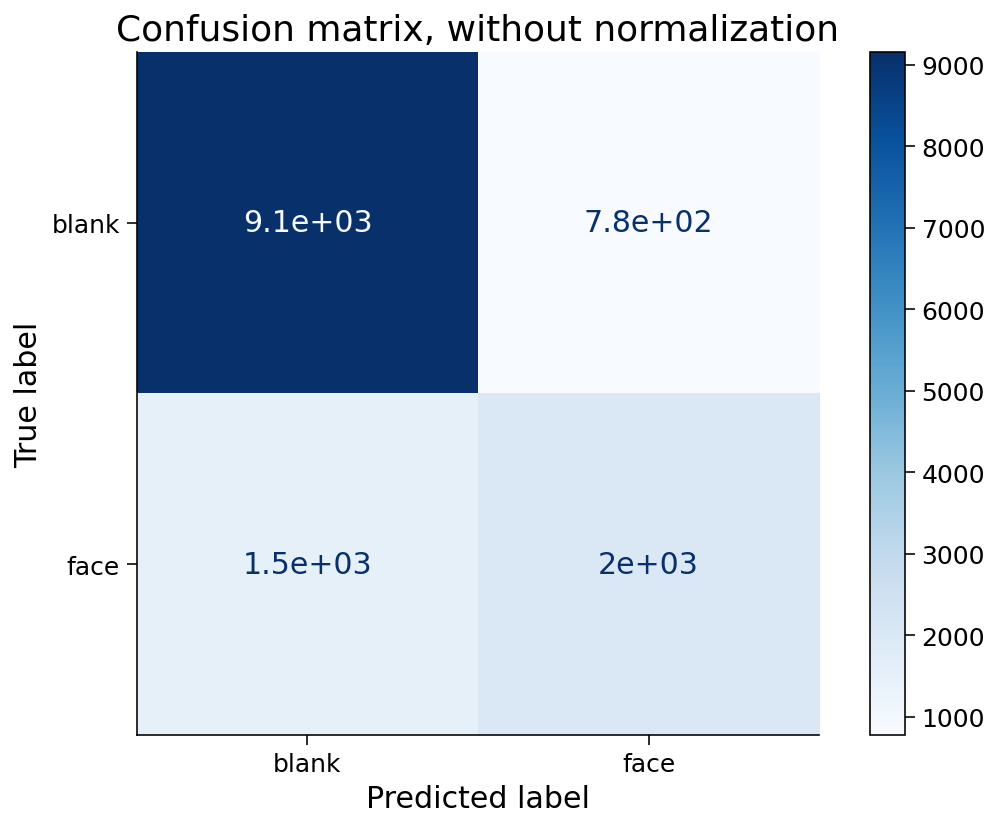

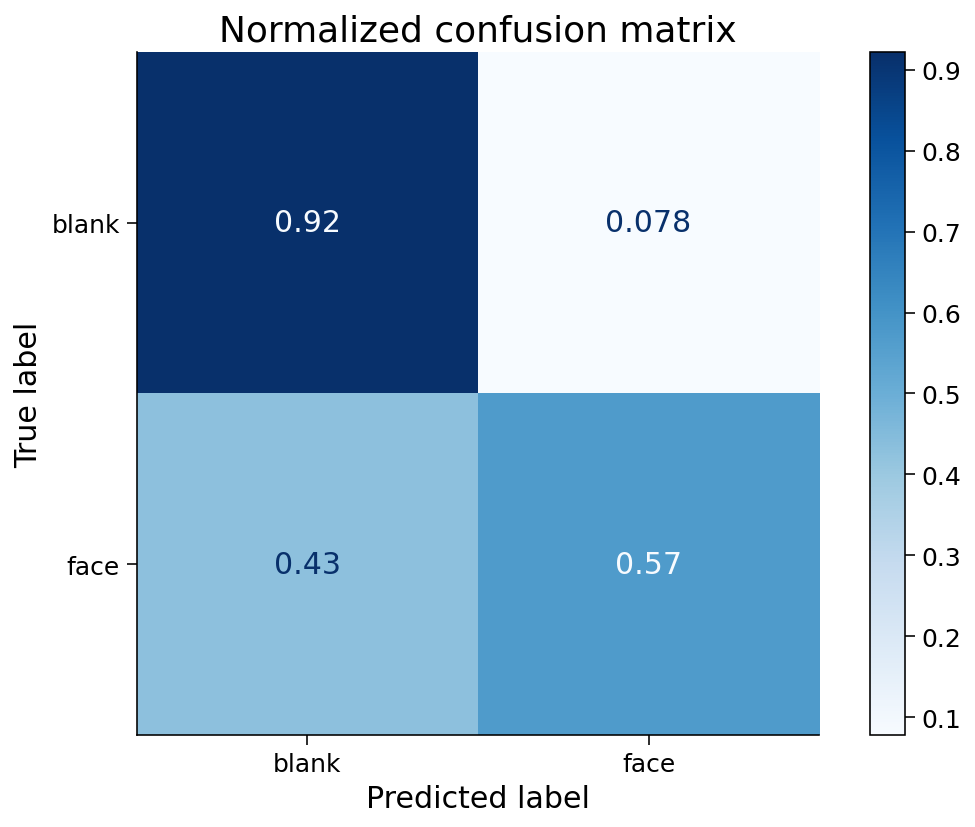

In [ ]:
class_names = ['blank', 'face']
from sklearn.metrics import plot_confusion_matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(anova_svc, X_test, Y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()